# FoReS (Foundation Recommender System)
A recommender system for people that are new to the world of foundations and don't know where to start. Basically it recommends you a foundation shades based on your skin tone using Fitzpatrick scale.

In [ ]:
%pip install torch torchvision

## Import the necessary package

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [25]:
using_colab = False

In [26]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib torch torchvision
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

In [32]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Data Exploration Analysis

In [2]:
# Count the number of train and val images
train_data = pd.read_csv('datasets/fitzpatrick/train.csv')
test_data = pd.read_csv('datasets/fitzpatrick/test.csv')
train_images = len(os.listdir("datasets/fitzpatrick/fairface/train/"))
test_images = len(os.listdir("datasets/fitzpatrick/fairface/val/"))

print(f"Train data: {len(train_data)}")
print(f"Test data: {len(test_data)}")
print(f"Train images: {train_images}")
print(f"Test images: {test_images}")

Train data: 35430
Test data: 4515
Train images: 35445
Test images: 4535


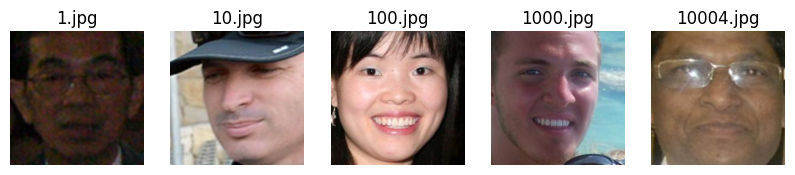

In [3]:
# Display 5 images from train folder using PIL
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    image = cv2.imread(f"datasets/fitzpatrick/fairface/train/{train_data.iloc[i]['file']}")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(train_data.iloc[i]['file'].split('/')[0])
    plt.axis('off')
plt.show()

## Images Preprocessing

### Image Segmentation

In [34]:
img = cv2.imread("datasets/fitzpatrick/fairface/train/10.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
device = "cuda"
# TODO: Change the model name and checkpoint path
model_name = "<model_name>"
model_checkpoint = "path/to/checkpoint"
sam = sam_model_registry[model_name](checkpoint=model_checkpoint)
if using_colab:
    sam.to(device=device)
mask_gen = SamAutomaticMaskGenerator(sam)
masks = mask_gen.generate(img)

In [41]:
print(f"Mask Length: {len(masks)}")
print(masks[0].keys())

Mask Length: 15
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


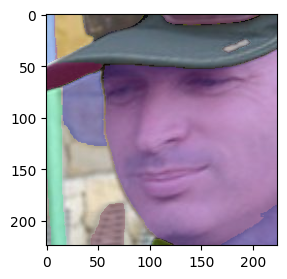

In [50]:
plt.figure(figsize=(3, 3))
plt.imshow(img)
show_anns(masks)
plt.show()